#### Bibliotecas

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox
import os
import re
import rasterio
from rasterio.mask import mask
from tqdm import tqdm
import networkx as nx
import itertools
import time
from geopy.distance import great_circle
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from shapely.geometry import Point
import matplotlib.patches as mpatches



#### Parâmetros

In [2]:
subprefeituras_shp = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_subprefeitura/SIRGAS_SHP_subprefeitura_polygon.shp'
zonas_shp_OD_2023 = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/PESQUISA_ORIGEM_E_DESTINO_2023_anexos/002_Site Metro Mapas/Shape/Zonas_2023.shp'
verbose = True

# Diretórios e configurações
output_folder = r'/Volumes/MiniArmstro/Resultados'

# Determinar os pixels acima do threshold
threshold = 70  # Valor informado em milímetros, mas convertido para metros, em função do raster. Valor obtido a partir da IC do Rodrigo.
threshold_max = 300 # Valor obtido a partir do paper da Pregnolato. Novamente, valor informado em milímetros, mas convertido para metros.

# Considerando que a primeira linha contém os cabeçalhos e as zonas começam de 1
arquivo_matrizOD = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/PESQUISA_ORIGEM_E_DESTINO_2023_anexos/Tabelas_Site_OD2023_120225.xlsx'
matriz_od_25 = pd.read_excel(arquivo_matrizOD, header=7, sheet_name='tab25', index_col=0)
# Exibir as primeiras linhas do DataFrame para verificação
#print(matriz_od_25.head())

blue = "\033[34m"
reset = "\033[0m"

#### Definindo os boundary boxes

In [3]:
# Carregar o arquivo CSV com as subprefeituras selecionadas
df_subprefeituras = pd.read_csv("resultados_ordenados_alagamentos.csv")

# Selecionar as 10 subprefeituras com maior índice de alagamento
df_sp_lista = df_subprefeituras.sort_values(by="Média", ascending=False).head(10)
#TODO Explicar bem esse critério dentro do capítulo de método

# Carregar o shapefile das subprefeituras
gdf = gpd.read_file(subprefeituras_shp)

# Filtrar o GeoDataFrame para manter apenas as subprefeituras da lista
gdf_sp_filtrado = gdf[gdf["sp_nome"].isin(df_sp_lista["sp_nome"])]

# Salvar em disco (GeoPackage e Parquet)
#bbox_gdf.to_file("bounding_boxes.gpkg", driver="GPKG")
#bbox_gdf.to_parquet("bounding_boxes.parquet")

print("Bounding boxes geradas com sucesso!")

# Define the UTM Zone 23S coordinate system
utm_crs = CRS("EPSG:31983")  # UTM Zone 23S, southern hemisphere

# Atribuição do esquema de projeção
gdf_sp_filtrado = gdf_sp_filtrado.set_crs(utm_crs)

# Verificar o CRS atual
print("CRS Atual:", gdf_sp_filtrado.crs)

# Calcular a área em km²
gdf_sp_filtrado["Área_km2"] = (gdf_sp_filtrado.area / 1e6).round(2)  # Convertendo de m² para km²

# Exibir os 10 primeiros valores
gdf_sp_filtrado[["sp_nome", "Área_km2"]]


Bounding boxes geradas com sucesso!
CRS Atual: EPSG:31983


,sp_nome,Área_km2
1,CASA VERDE-CACHOEIRINHA,27.23
2,LAPA,40.64
4,SE,26.66
5,SANTANA-TUCURUVI,35.78
6,PINHEIROS,31.99
8,VILA MARIA-VILA GUILHERME,26.90
9,MOOCA,36.04
14,SAO MIGUEL,26.15
16,ARICANDUVA-FORMOSA-CARRAO,22.33
25,SANTO AMARO,37.74


In [4]:
# Explorar o mapa diretamente no Jupyter Notebook
gdf_sp_filtrado.explore(
    column="sp_nome",  # Colore cada bounding box de forma diferente
    cmap="Set1",  # Escolhe uma paleta de cores
    tooltip="sp_nome",  # Mostra o nome da subprefeitura ao passar o mouse
    popup=True,  # Exibe mais detalhes ao clicar
    tiles="CartoDB positron"  # Define o mapa base
)

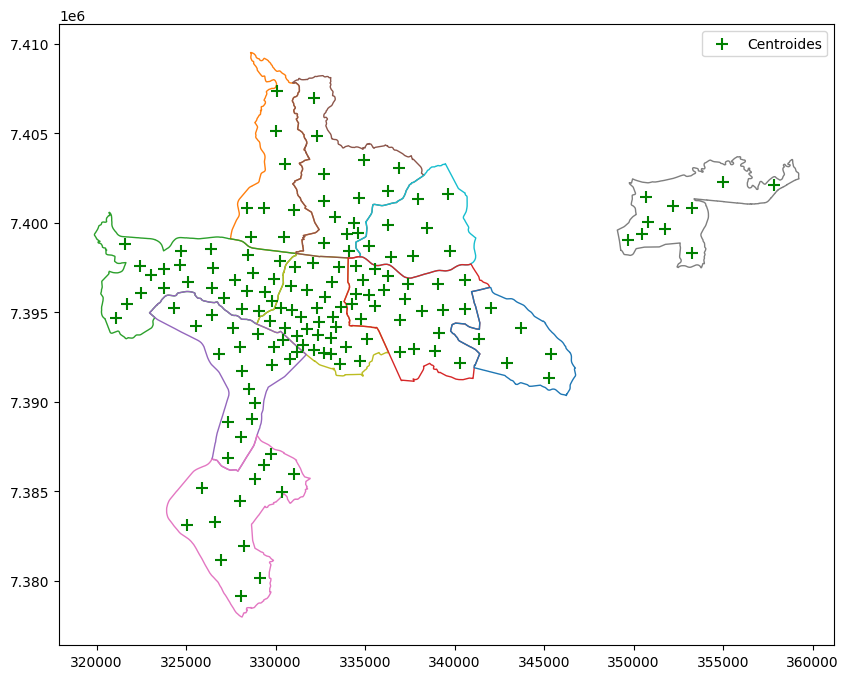

In [5]:
gdf_zonas_OD_2023 = gpd.read_file(zonas_shp_OD_2023)

# Atribuição do esquema de projeção
gdf_zonas_OD_2023_utm = gdf_zonas_OD_2023.to_crs(utm_crs)

# Filtrando para o munícipio de São Paulo
gdf_zonas_OD_SP_2023_utm = gdf_zonas_OD_2023_utm[gdf_zonas_OD_2023_utm['NomeMunici'] == 'São Paulo'].copy()

# Obtendo os centroides
gdf_zonas_OD_SP_2023_utm["centroid"] = gdf_zonas_OD_SP_2023_utm["geometry"].centroid

# Garantir que ambos os GeoDataFrames têm o mesmo CRS
gdf_zonas_OD_SP_2023_utm = gdf_zonas_OD_SP_2023_utm.to_crs(gdf_sp_filtrado.crs)

# Filtrar apenas os centroides que estão dentro das subprefeituras selecionadas
centroids = gdf_zonas_OD_SP_2023_utm['centroid']
centroids_filtrados = centroids[centroids.within(gdf_sp_filtrado.union_all())]

# Criar a figura e os eixos
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar as subprefeituras
gdf_sp_filtrado.plot(ax=ax, column='sp_nome', facecolor='none', linewidth=1)

# Extraindo coordenadas dos centroides filtrados
x = centroids_filtrados.x
y = centroids_filtrados.y

# Plotar os centroides filtrados como estrelas (*)
ax.scatter(x, y, color='green', marker='+', s=70, label="Centroides")

# Adicionar legenda
ax.legend()

# Exibir o mapa
plt.show()

In [6]:
# Criar um GeoDataFrame apenas com os centroides
gdf_centroids = gpd.GeoDataFrame(geometry=gdf_zonas_OD_SP_2023_utm['centroid'], crs=gdf_sp_filtrado.crs)

# Fazer a junção espacial para associar centroides às subprefeituras
joined = gpd.sjoin(gdf_centroids, gdf_sp_filtrado, predicate='within', how='left')

# Contar quantos centroides existem por subprefeitura
centroid_counts = joined.groupby("sp_nome").size().reset_index(name="Num_Centroides")

# Exibir o resultado
print(centroid_counts)

                     sp_nome  Num_Centroides
0  ARICANDUVA-FORMOSA-CARRAO               6
1    CASA VERDE-CACHOEIRINHA               8
2                       LAPA              25
3                      MOOCA              23
4                  PINHEIROS              19
5           SANTANA-TUCURUVI              14
6                SANTO AMARO              13
7                 SAO MIGUEL              10
8                         SE              29
9  VILA MARIA-VILA GUILHERME               8


#### Extrair a rede viária

CRS atual do edges_baseline: epsg:4326
CRS do edges_baseline_reprojected: EPSG:31983
Grafo obtido com sucesso!
Sub-prefeitura selecionada:  CASA VERDE-CACHOEIRINHA


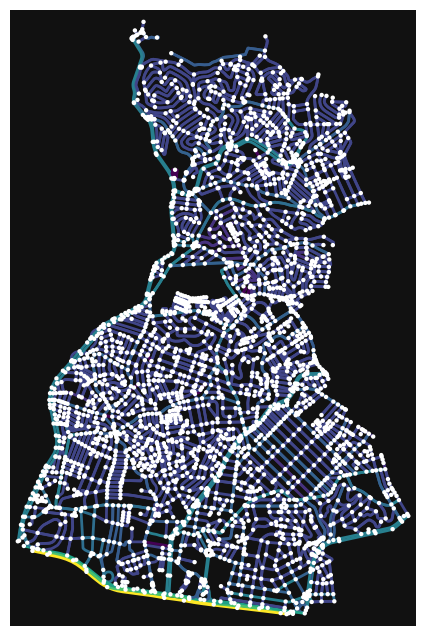

In [7]:
# Dados da subprefeitura
indice_sp = 0
nome_sp = gdf_sp_filtrado.iloc[indice_sp]['sp_nome']

# Verifica e define o CRS
if gdf_sp_filtrado.crs is None:
    gdf_sp_filtrado.set_crs(epsg=4326, inplace=True)  # Define como WGS 84 (latitude/longitude)

# Extrai a geometria
poligono = gdf_sp_filtrado.iloc[indice_sp].geometry

# Certifique-se de que o polígono está em EPSG:4326 (necessário para OSMNX)
if gdf_sp_filtrado.crs.to_epsg() != 4326:
    poligono = gdf_sp_filtrado.to_crs(epsg=4326).iloc[indice_sp].geometry

# Obtém o grafo
G_baseline = ox.graph_from_polygon(poligono, network_type="drive")
G_baseline = ox.routing.add_edge_speeds(G_baseline, fallback=50)  # Adiciona a velocidade dos eixos (km/h) ao grafo como o atributo do eixo speed_kph

node_baseline, edges_baseline = ox.graph_to_gdfs(G_baseline)

# Verificar o CRS atual
print("CRS atual do edges_baseline:", edges_baseline.crs)

# Reprojetar para EPSG:31983
edges_baseline_reprojected = edges_baseline.to_crs(epsg=31983)

# Verificar se a reprojeção foi bem-sucedida
print("CRS do edges_baseline_reprojected:", edges_baseline_reprojected.crs)

if verbose:
    print("Grafo obtido com sucesso!")
    print('Sub-prefeitura selecionada: ',nome_sp)
    # Obtendo os comprimentos das arestas
    velocidades = [data['speed_kph'] for _, _, data in G_baseline.edges(data=True)]

    # Normalizando para um mapa de cores
    norm = mcolors.Normalize(vmin=min(velocidades), vmax=max(velocidades))
    cmap = cm.viridis  # Escolha um mapa de cores

    # Definir cores baseadas na velocidade
    edge_colors = [cmap(norm(l)) for l in velocidades]

    # Plotando com cores personalizadas
    fig, ax = ox.plot_graph(
        G_baseline, 
        edge_color=edge_colors, 
        node_size=10, 
        edge_linewidth=2
    )


#### Recortes dos raster em função dos boundary boxes

In [ ]:
# Somente executar este trecho uma única vez
# Carregar o GeoDataFrame das subprefeituras
gdf_sp = gdf_sp_filtrado

# Listar pacotes válidos
pacotes = [p for p in os.listdir(output_folder) if p.startswith("Pacote_") and p[-2:].isdigit()]

print(f"{len(pacotes)} pacotes identificados. Iniciando processamento...\n")

# Processamento
for pacote in tqdm(pacotes, desc="Processando Pacotes"):
    pacote_path = os.path.join(output_folder, pacote)
    simulacao_path = os.path.join(pacote_path, "Simulação")
    subprefeituras_path = os.path.join(pacote_path, "Sub-prefeituras")
    
    # Criar diretório de Subprefeituras se não existir
    os.makedirs(subprefeituras_path, exist_ok=True)
    
    # Filtrar subprefeituras dentro do pacote
    for _, subpref in tqdm(gdf_sp.iterrows(), total=len(gdf_sp), desc=f"Subprefeituras ({pacote})", leave=False):
        sp_nome = subpref["sp_nome"]
        sp_path = os.path.join(subprefeituras_path, sp_nome)
        os.makedirs(sp_path, exist_ok=True)
        
        # Verificar existência da pasta simulação
        if not os.path.exists(simulacao_path):
            print(f"[AVISO] Pasta 'simulação' não encontrada em {pacote}. Pulando...")
            continue
        
        # Processar arquivos .tif
        tif_files = [f for f in os.listdir(simulacao_path) if f.endswith(".tif") and not f.startswith("._")]
        for filename in tqdm(tif_files, desc=f"Clipando ({sp_nome})", leave=False):
            src_path = os.path.join(simulacao_path, filename)
            
            try:
                with rasterio.open(src_path) as src:
                    if gdf_sp.crs != src.crs:
                        gdf_sp = gdf_sp.to_crs(src.crs)
                    
                    sp_geometry = [subpref.geometry]
                    raster_bounds = box(*src.bounds)
                    if not raster_bounds.intersects(subpref.geometry):
                        print(f"[INFO] {filename} não sobrepõe {sp_nome}. Pulando...")
                        continue
                    
                    out_image, out_transform = mask(src, sp_geometry, crop=True)
                    out_meta = src.meta.copy()
                    out_meta.update({
                        "driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform,
                        "crs": src.crs
                    })
                    
                    output_filename = f"{os.path.splitext(filename)[0]}_{sp_nome}.tif"
                    output_path = os.path.join(sp_path, output_filename)
                    with rasterio.open(output_path, "w", **out_meta) as dest:
                        dest.write(out_image)
                    
                    #print(f"[SUCESSO] Arquivo clipado salvo: {output_path}")
            except Exception as e:
                print(f"[ERRO] Falha ao processar {filename}: {e}")

print("\nProcessamento concluído para todos os pacotes e subprefeituras!")

#### Aproximar os pares OD da rede OSMnx

Carregando dados...
Processando subprefeitura: CASA VERDE-CACHOEIRINHA


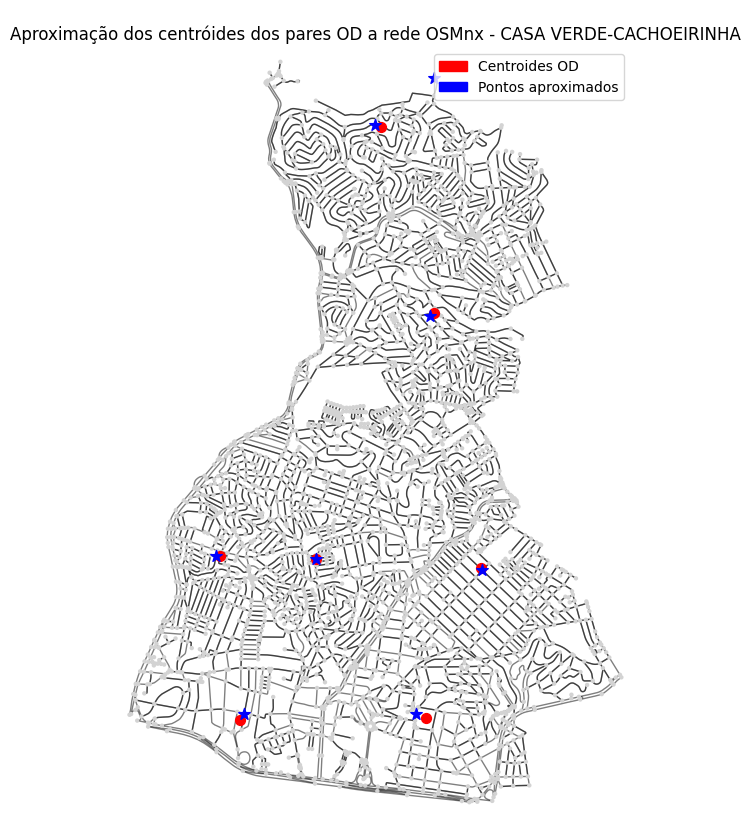

Processamento concluído!


In [8]:
# Definição do CRS UTM para São Paulo
utm_crs = CRS("EPSG:32723")  # UTM Zone 23S

# Ler os dados
print("Carregando dados...")
gdf_OD = gpd.read_file(zonas_shp_OD_2023).to_crs(utm_crs)
gdf_OD_SP = gdf_OD[gdf_OD['NomeMunici'] == 'São Paulo'].copy()
gdf_sp_filtrado = gdf_sp_filtrado.to_crs(utm_crs)

# Iterar sobre cada subprefeitura (aqui, limitado à primeira para teste)
resultados = {}
for idx, subprefeitura in gdf_sp_filtrado.iloc[:1].iterrows():
    nome_subprefeitura = subprefeitura["sp_nome"]
    print(f"Processando subprefeitura: {nome_subprefeitura}")
    
    # Criar GeoDataFrame da subprefeitura (em UTM)
    gdf_subpref_utm = gpd.GeoDataFrame(geometry=[subprefeitura["geometry"]], crs=utm_crs)
    
    # Converter para EPSG:4326 para extrair a rede com OSMnx (se necessário)
    if gdf_subpref_utm.crs.to_epsg() != 4326:
        gdf_subpref_4326 = gdf_subpref_utm.to_crs(epsg=4326)
        poligono = gdf_subpref_4326.iloc[0].geometry
    else:
        poligono = subprefeitura["geometry"]

    # Extrair o grafo para a área do polígono e adicionar velocidades (km/h)
    G_baseline = ox.graph_from_polygon(poligono, network_type="drive")
    G_baseline = ox.routing.add_edge_speeds(G_baseline, fallback=50)
    
    # Projetar o grafo para UTM
    G_baseline_utm = ox.project_graph(G_baseline, to_crs=utm_crs)
    
    # Cria um GeoDataFrame com os centróides dos pontos OD
    gdf_OD_centroids = gdf_OD_SP.copy()
    gdf_OD_centroids["centroide"] = gdf_OD_centroids.geometry.centroid
    # Importante: definir o CRS como o utm_crs, pois os dados já foram convertidos
    gdf_OD_centroids = gpd.GeoDataFrame(gdf_OD_centroids, geometry="centroide", crs=utm_crs)
    
    # Define o polígono da subprefeitura para a junção espacial
    subpref_polygon = gdf_subpref_utm

    # Realiza a junção espacial para identificar os centróides dentro da subprefeitura
    gdf_centroids_in_subpref = gdf_OD_centroids.sjoin(subpref_polygon, how="inner", predicate="within")
    
    # Agora, usamos os centróides que caíram dentro da subprefeitura
    centroides_df = gdf_centroids_in_subpref.copy()
    
    # Aproximar os pontos à rede: encontrar o nó mais próximo para cada centroide
    coluna_nome = f"nearest_node_{nome_subprefeitura.replace(' ', '_')}"
    centroides_df[coluna_nome] = centroides_df.geometry.apply(
        lambda point: ox.distance.nearest_nodes(G_baseline_utm, point.x, point.y)
    )
    
    # Obter coordenadas dos nós aproximados
    centroides_df["node_x"] = centroides_df[coluna_nome].map(lambda node: G_baseline_utm.nodes[node]["x"])
    centroides_df["node_y"] = centroides_df[coluna_nome].map(lambda node: G_baseline_utm.nodes[node]["y"])
    
    # Criar GeoDataFrame com os nós aproximados
    gdf_nos_aproximados = gpd.GeoDataFrame(
        centroides_df,
        geometry=gpd.points_from_xy(centroides_df["node_x"], centroides_df["node_y"]),
        crs=utm_crs
    )
    
    # Armazenar resultado
    resultados[nome_subprefeitura] = gdf_nos_aproximados
    
    # Plotar: grafo, centróides originais e nós aproximados
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plota o grafo OSMnx no ax já criado
    fig, ax = ox.plot_graph(
        G_baseline_utm, ax=ax, node_color='lightgray', node_size=10,
        edge_color='black', edge_alpha=0.5, show=False, close=False
    )

    # Plota os centróides dos pontos OD (apenas os que estão dentro da subprefeitura)
    centroides_df.plot(ax=ax, marker='o', color='red', markersize=50, label='Centroides OD', zorder=3)

    # Plota os pontos aproximados (nós da rede)
    gdf_nos_aproximados.plot(
        ax=ax, marker='*', color='blue', markersize=75,
        label='Pontos aproximados', zorder=4
    )
    
    plt.title(f'Aproximação dos centróides dos pares OD a rede OSMnx - {nome_subprefeitura}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Cria legendas
    legenda_centroides = mpatches.Patch(color='red', label='Centroides OD')
    legenda_aprox = mpatches.Patch(color='blue', label='Pontos aproximados')
    plt.legend(handles=[legenda_centroides, legenda_aprox])
    
    plt.show()

# Combinar todos os GeoDataFrames em um único
resultado_final = gpd.GeoDataFrame(pd.concat(resultados.values(), ignore_index=True))

print("Processamento concluído!")


#### Funções de apoio

In [9]:
def filtrar_centroides_por_subprefeitura(gdf_zonas, gdf_subprefeituras, subprefeitura, utm_crs):
    """
    Filtra os centroides das zonas OD que estão dentro de uma determinada subprefeitura.

    Parâmetros:
    - gdf_zonas: GeoDataFrame das zonas OD
    - gdf_subprefeituras: GeoDataFrame das subprefeituras, contendo a coluna 'sp_nome'
    - subprefeitura: Nome da subprefeitura a ser filtrada
    - utm_crs: Sistema de referência de coordenadas UTM a ser usado

    Retorna:
    - Um GeoDataFrame contendo os centroides filtrados
    """

    # Atribuir o esquema de projeção
    gdf_zonas_utm = gdf_zonas.to_crs(utm_crs)

    # Filtrar para o município de São Paulo
    gdf_zonas_sp = gdf_zonas_utm[gdf_zonas_utm['NomeMunici'] == 'São Paulo'].copy()

    # Criar a coluna de centroides
    gdf_zonas_sp["centroid"] = gdf_zonas_sp["geometry"].centroid

    # Garantir que ambos os GeoDataFrames têm o mesmo CRS
    gdf_zonas_sp = gdf_zonas_sp.to_crs(gdf_subprefeituras.crs)

    # Criar um GeoDataFrame com os centroides
    centroids_gdf = gpd.GeoDataFrame(gdf_zonas_sp[['centroid']], geometry='centroid', crs=gdf_subprefeituras.crs)

    # Realizar o spatial join para adicionar a subprefeitura a cada centróide
    centroids_filtrados = gpd.sjoin(centroids_gdf, gdf_subprefeituras[['geometry', 'sp_nome']], how='inner', predicate='within')

    # Filtrar para a subprefeitura específica
    centroids_filtrados = centroids_filtrados[centroids_filtrados['sp_nome'] == subprefeitura]

    return centroids_filtrados

In [10]:
def adjust_speed_batch(row, raster_data, transform, threshold, threshold_max, speed_column):
    """
    Ajusta a velocidade de um segmento com base na profundidade do alagamento extraída de um raster.

    Parâmetros:
        row (GeoSeries): Linha atual do GeoDataFrame contendo informações de velocidade e geometria.
        raster_data (numpy.ndarray): Dados do raster contendo profundidade de alagamento.
        transform (Affine): Transformação do raster para coordenadas espaciais.
        threshold (float): Profundidade mínima para ajustar a velocidade.
        threshold_max (float): Profundidade máxima que torna a via intransitável.
        speed_column (str): Nome da coluna de referência para a velocidade original.
    
    Retorno:
        float: Velocidade ajustada para o segmento.
    """

    # Encontrar a coordenada do centro do segmento
    centroid = row.geometry.centroid

    # Transformar as coordenadas do centroide em índices do raster
    try:
        col_idx, row_idx = ~transform * (centroid.x, centroid.y) # Observe a ordem inversa
        row_idx, col_idx = int(row_idx), int(col_idx)
    except Exception:
        # Caso algo dê errado na transformação, manter a velocidade original
        #print('Mantive a velocidade que veio!')
        return row[speed_column]

    # Verificar se os índices estão dentro dos limites do raster
    if not (0 <= row_idx < raster_data.shape[0] and 0 <= col_idx < raster_data.shape[1]):
        print(row_idx, raster_data.shape[0], col_idx, raster_data.shape[1])
        return row[speed_column]
    
    # Extração do valor de profundidade do raster
    flood_depth = 1000*raster_data[row_idx, col_idx] # Valor extraído do raster em metros
    #print(flood_depth)

    # Ajustar a velocidade com base na profundidade
    if flood_depth > threshold_max:
        # Caso a altura exceda o limiar máximo, torna-se instransitável
        return 0
    elif flood_depth > threshold:
        # Aplicar a fórmula de ajuste da velocidade
        adjusted_speed = 0.0009 * (flood_depth ** 2) - 0.5529 * flood_depth + 86.9448
        #print('Pregnolato!')
        return min(adjusted_speed, row[speed_column])  # Garantir que não ultrapasse a velocidade original
        
    # Caso contrário, manter a velocidade original
    return row[speed_column]

In [11]:
def listar_atributos_arestas(G):
    atributos = set()
    for _, _, dados in G.edges(data=True):
        atributos.update(dados.keys())
    return atributos

# 1. Função para obter o número de viagens da matriz OD
def get_number_of_trips(node1, node2, referencia, od_matrix):
    zone1 = gdf_nos_aproximados.loc[gdf_nos_aproximados[referencia] == node1, 'NumeroZona'].values[0]
    zone2 = gdf_nos_aproximados.loc[gdf_nos_aproximados[referencia] == node2, 'NumeroZona'].values[0]
    #print(f'O número de viagens entre {zone1} e {zone2} é {od_matrix.loc[zone1, zone2]}')
    return od_matrix.loc[zone1, zone2]

def tempo_medio_viagem(arquivo):

    # Filtrar os valores finitos para tempo com peso e num_viagens
    finite_mask_baseline = np.isfinite(arquivo['Tempo ponderado (min)'])
    finite_tempos_e_viagens_baseline = arquivo[finite_mask_baseline]

    # Calcular o número total de viagens sem valores infinitos
    total_trips_weighted = finite_tempos_e_viagens_baseline['Num_viagens'].sum()

    # Calcular o tempo total sem peso ignorando valores infinitos
    total_time_weighted = finite_tempos_e_viagens_baseline['Tempo ponderado (min)'].sum()

    # Calcular o tempo médio de viagem ponderado
    mean_time_weighted = total_time_weighted / total_trips_weighted

    # Exibir os resultados
    #print(f"Tempo médio de viagem com chuva e ponderado: {mean_time_weighted:.2f} minutos")

    return mean_time_weighted

#### Produzir novas referências de velocidade

In [12]:
pacote_num = 'Pacote_01'

# Construir o caminho completo do diretório onde estão os arquivos TIFF
clipado_path = os.path.join(output_folder, pacote_num, 'Sub-prefeituras', nome_sp)

# Verificar se o diretório existe antes de continuar
if not os.path.isdir(clipado_path):
    raise FileNotFoundError(f"O diretório {clipado_path} não foi encontrado.")

# Obter a lista de arquivos TIFF no diretório
arquivos_tif = [f for f in os.listdir(clipado_path) if f.endswith(".tif") and not f.startswith("._")]

# Total de arquivos a serem processados
total_arquivos = len(arquivos_tif)

# Função para extrair o número que aparece depois de "h_" ou "max_"
def extrair_numero(nome):
    match = re.search(r'(?:h_|max_)(\d+)', nome)  # Captura o número após "h_" ou "max_"
    return int(match.group(1)) if match else float('inf')  # Retorna um número grande se não encontrar nada

# Ordenar a lista com base no número extraído
arquivos_ordenados = sorted(arquivos_tif, key=extrair_numero)

# Exibir a lista ordenada
for arquivo in arquivos_ordenados:
    print(arquivo)

pct1_h_2692800_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2696400_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2700000_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2703600_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2707200_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2710800_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2714400_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2718000_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2721600_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2725200_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2728800_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2732400_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2736000_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2739600_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2743200_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2746800_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2750400_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2754000_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2757600_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2761200_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2764800_CASA VERDE-CACHOEIRINHA.tif
pct1_h_max_2768400_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2768400_CASA VERDE-CACHOEIRINHA.tif


In [13]:
# Verificar que as colunas não estão presentes no GDF. 
# Particularmente, verificar se a coluna speed_kph foi adicionada.
# Ela será a referência de velocidade
edges_baseline_reprojected.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 7874 entries, (np.int64(25783581), np.int64(2387001370), np.int64(0)) to (np.int64(12595592440), np.int64(12595592438), np.int64(0))
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   osmid      7874 non-null   object  
 1   highway    7874 non-null   object  
 2   lanes      1774 non-null   object  
 3   maxspeed   1285 non-null   object  
 4   oneway     7874 non-null   bool    
 5   reversed   7874 non-null   object  
 6   length     7874 non-null   float64 
 7   geometry   7874 non-null   geometry
 8   speed_kph  7874 non-null   float64 
 9   name       7520 non-null   object  
 10  ref        10 non-null     object  
 11  junction   44 non-null     object  
 12  access     58 non-null     object  
 13  width      26 non-null     object  
 14  bridge     15 non-null     object  
dtypes: bool(1), float64(2), geometry(1), object(11)
memory usage: 1.1+ MB


In [14]:
# Iterar sobre os arquivos clipados
for index, filename in enumerate(arquivos_ordenados, start=1):  # Começa em 1
    print(f"\nProcessando arquivo {index} de {total_arquivos}: {filename}")

    # Extrair informações do nome do arquivo
    match = re.search(r'pct(?P<pct>\d+)_h(?:_max)?_(?P<value>\d+)', filename)
    if match:
        pct = match.group('pct')  # Valor após "pct"
        value = match.group('value')  # Valor numérico
        is_max = '_max' in filename  # Verificar se "max" está presente

        # Criar o nome da coluna dinamicamente
        column_suffix = f"pct{pct}_h_{value}" + ("_max" if is_max else "")
        column_name = column_suffix  # Exemplo: "pct1_h_2692800" ou "pct1_h_max_2768400"
        #print(f"Coluna gerada: {column_name}")

        # Caminho completo do arquivo raster
        raster_path = os.path.join(clipado_path, filename)

        # Abrir o raster e extrair os dados
        with rasterio.open(raster_path) as src:
            raster_data = src.read(1)  # Ler a primeira banda do raster
            raster_transform = src.transform

        # Aplicar a função de ajuste e criar uma nova coluna
        edges_baseline_reprojected[column_name] = edges_baseline_reprojected.apply(
            adjust_speed_batch,
            axis=1,
            args=(raster_data, raster_transform, threshold, threshold_max, 'speed_kph')
        )

        #vel_ajustada = edges_baseline_reprojected.copy()
        # Cria uma coluna com a diferença entre a velocidade original e a ajustada
        #vel_ajustada['speed_diff'] = vel_ajustada['speed_kph'] - vel_ajustada[column_name]

        # Estatísticas descritivas da velocidade ajustada
        #print("Estatísticas da velocidade ajustada:")
        #print(edges_baseline_reprojected[column_name].describe())

        # Estatísticas descritivas da diferença (quanto a velocidade foi reduzida)
        #print("\nEstatísticas da diferença de velocidade:")
        #print(vel_ajustada[column_name].describe())

        # Número de segmentos que tiveram a velocidade modificada
        #num_modificados = (vel_ajustada['speed_diff'] != 0).sum()
        #total_segmentos = len(vel_ajustada)
        #print(f"\nSegmentos com velocidade alterada: {num_modificados} de {total_segmentos}")
        #print(f"Percentual de segmentos alterados: {num_modificados/total_segmentos*100:.2f}%")

        # Quantas velocidades foram ajustadas para zero
        count_zero = (edges_baseline_reprojected[column_name] == 0).sum()

        # Quantas velocidades foram modificadas (diferentes da original e não zero)
        count_modified = ((edges_baseline_reprojected[column_name] != edges_baseline_reprojected["speed_kph"]) & (edges_baseline_reprojected[column_name] != 0)).sum()

        # Quantas velocidades permaneceram iguais à original
        count_unchanged = (edges_baseline_reprojected[column_name] == edges_baseline_reprojected["speed_kph"]).sum()

        print(f"Velocidades ajustadas para zero: {count_zero} ou {count_zero/len(edges_baseline_reprojected)*100:.2f}%")
        print(f"Velocidades modificadas:{count_modified} ou {count_modified/len(edges_baseline_reprojected)*100:.2f}%")
        print(f"Velocidades inalteradas: {count_unchanged} ou {count_unchanged/len(edges_baseline_reprojected)*100:.2f}%")

print("\nProcessamento concluído!\n")


Processando arquivo 1 de 23: pct1_h_2692800_CASA VERDE-CACHOEIRINHA.tif
Velocidades ajustadas para zero: 0 ou 0.00%
Velocidades modificadas:0 ou 0.00%
Velocidades inalteradas: 7874 ou 100.00%

Processando arquivo 2 de 23: pct1_h_2696400_CASA VERDE-CACHOEIRINHA.tif
Velocidades ajustadas para zero: 3 ou 0.04%
Velocidades modificadas:1 ou 0.01%
Velocidades inalteradas: 7870 ou 99.95%

Processando arquivo 3 de 23: pct1_h_2700000_CASA VERDE-CACHOEIRINHA.tif
Velocidades ajustadas para zero: 56 ou 0.71%
Velocidades modificadas:6 ou 0.08%
Velocidades inalteradas: 7812 ou 99.21%

Processando arquivo 4 de 23: pct1_h_2703600_CASA VERDE-CACHOEIRINHA.tif
Velocidades ajustadas para zero: 120 ou 1.52%
Velocidades modificadas:48 ou 0.61%
Velocidades inalteradas: 7706 ou 97.87%

Processando arquivo 5 de 23: pct1_h_2707200_CASA VERDE-CACHOEIRINHA.tif
Velocidades ajustadas para zero: 312 ou 3.96%
Velocidades modificadas:114 ou 1.45%
Velocidades inalteradas: 7448 ou 94.59%

Processando arquivo 6 de 23: p

In [15]:
# Verifique se as novas colunas foram adicionadas
# Aqui estamos procurando se as colunas com as horas de simulação foram adicionadas.
print(edges_baseline_reprojected.columns)

Index(['osmid', 'highway', 'lanes', 'maxspeed', 'oneway', 'reversed', 'length',
       'geometry', 'speed_kph', 'name', 'ref', 'junction', 'access', 'width',
       'bridge', 'pct1_h_2692800', 'pct1_h_2696400', 'pct1_h_2700000',
       'pct1_h_2703600', 'pct1_h_2707200', 'pct1_h_2710800', 'pct1_h_2714400',
       'pct1_h_2718000', 'pct1_h_2721600', 'pct1_h_2725200', 'pct1_h_2728800',
       'pct1_h_2732400', 'pct1_h_2736000', 'pct1_h_2739600', 'pct1_h_2743200',
       'pct1_h_2746800', 'pct1_h_2750400', 'pct1_h_2754000', 'pct1_h_2757600',
       'pct1_h_2761200', 'pct1_h_2764800', 'pct1_h_2768400_max',
       'pct1_h_2768400'],
      dtype='object')


#### Calcular os tempos de viagem

In [16]:
def add_edge_travel_times_gdf2(gdf, referencia):
    import re
    import numpy as np

    # Extrair a parte relevante da referência (até a segunda sequência numérica)
    padrao = r'^((?:[^\d]*\d+){2}).*'
    ref_clean = re.sub(padrao, r'\1', referencia)
    
    col_speed = ref_clean
    col_tt = f'tt_{ref_clean}'
    
    print(f'O valor da referência é: {col_tt}')
    
    # Garantir a existência da coluna de velocidade; se não existir, criar com valor 0
    if col_speed not in gdf.columns:
        print(f'Aviso: a coluna "{col_speed}" não existe no GeoDataFrame. Criando-a com valor 0.')
        gdf[col_speed] = 0

    # Garantir que a coluna 'length' exista e preencher valores ausentes com 0
    if 'length' not in gdf.columns:
        print('Aviso: a coluna "length" não existe no GeoDataFrame. Criando-a com valor 0.')
        gdf['length'] = 0
    else:
        gdf['length'] = gdf['length'].fillna(0)

    # Calcular os tempos de viagem:
    # Se a velocidade é 0, atribuir infinito; caso contrário, calcular (length * 3.6) / velocidade.
    gdf[col_tt] = np.where(gdf[col_speed] == 0, np.inf, (gdf['length'] * 3.6) / gdf[col_speed])
    
    return gdf


In [17]:
# Aplicando a função para adicionar o tempo de viagem
data_batch = []
data = 0

for column_name in arquivos_ordenados:
    edges_simulados = add_edge_travel_times_gdf2(edges_baseline_reprojected, column_name)
    data_batch.append({
                    'index': data + 1,
                    'Referência': column_name.replace('.tif', ''), # Remove "_clp.tif" da referência.
                })
    data += 1

edges_simulados = add_edge_travel_times_gdf2(edges_baseline_reprojected, 'speed_kph') # Essa linha é necessária para construir o baseline no arquivo GDF
data_batch.append({
    'index': data,
    'Referência': 'speed_kph',
})

# Criar DataFrame com os resultados
detalhes_arquivo_df = pd.DataFrame(data_batch)

# Criando a coluna "Max" com valor 0 por padrão
detalhes_arquivo_df["Max"] = 0

# Encontrar a linha que contém "max_"
linha_max = detalhes_arquivo_df[detalhes_arquivo_df["Referência"].str.contains("max_", na=False)]

if not linha_max.empty:
    # Extrair o número após "max_"
    match = re.search(r"max_(\d+)", linha_max["Referência"].values[0])
    
    if match:
        numero_max = match.group(1)  # Captura apenas o número após "max_"
        
        # Atualizar a linha correspondente ao número extraído, definindo "Max" como 1
        detalhes_arquivo_df.loc[detalhes_arquivo_df["Referência"].str.contains(f"h_{numero_max}", na=False), "Max"] = 1

# Remover a linha que contém "max_"
detalhes_arquivo_df = detalhes_arquivo_df[~detalhes_arquivo_df["Referência"].str.contains("max_", na=False)]

# Resetar o índice para manter organizado
detalhes_arquivo_df.reset_index(drop=True, inplace=True)

O valor da referência é: tt_pct1_h_2692800
O valor da referência é: tt_pct1_h_2696400
O valor da referência é: tt_pct1_h_2700000
O valor da referência é: tt_pct1_h_2703600
O valor da referência é: tt_pct1_h_2707200
O valor da referência é: tt_pct1_h_2710800
O valor da referência é: tt_pct1_h_2714400
O valor da referência é: tt_pct1_h_2718000
O valor da referência é: tt_pct1_h_2721600
O valor da referência é: tt_pct1_h_2725200
O valor da referência é: tt_pct1_h_2728800
O valor da referência é: tt_pct1_h_2732400
O valor da referência é: tt_pct1_h_2736000
O valor da referência é: tt_pct1_h_2739600
O valor da referência é: tt_pct1_h_2743200
O valor da referência é: tt_pct1_h_2746800
O valor da referência é: tt_pct1_h_2750400
O valor da referência é: tt_pct1_h_2754000
O valor da referência é: tt_pct1_h_2757600
O valor da referência é: tt_pct1_h_2761200
O valor da referência é: tt_pct1_h_2764800
O valor da referência é: tt_pct1_h_max_2768400
Aviso: a coluna "pct1_h_max_2768400" não existe no

In [18]:
cols_interesse = [col for col in edges_baseline_reprojected.columns if col.startswith('tt')] + ['speed_kph']
# Substitui valores infinitos (positivos e negativos) por NaN
df_temp = edges_baseline_reprojected[cols_interesse].replace([np.inf, -np.inf], np.nan)
stats = df_temp.describe()
print(stats)

       tt_pct1_h_2692800  tt_pct1_h_2696400  tt_pct1_h_2700000  \
count        7874.000000        7871.000000        7818.000000   
mean            8.965813           8.969194           9.047312   
std             7.292226           7.302374           9.049260   
min             0.143217           0.143217           0.143217   
25%             4.012732           4.012166           4.012732   
50%             6.969162           6.969162           6.940216   
75%            11.864830          11.864830          11.851585   
max           116.909532         116.909532         373.147892   

       tt_pct1_h_2703600  tt_pct1_h_2707200  tt_pct1_h_2710800  \
count        7754.000000        7562.000000        7211.000000   
mean            9.012036           9.432840           9.449309   
std             7.539974          11.785621           8.901614   
min             0.143217           0.143217           0.143217   
25%             4.023658           4.064025           4.174256   
50%      

In [19]:
corr_matrix = edges_baseline_reprojected[cols_interesse].corr()
print(corr_matrix)


                       tt_pct1_h_2692800  tt_pct1_h_2696400  \
tt_pct1_h_2692800               1.000000           0.999310   
tt_pct1_h_2696400               0.999310           1.000000   
tt_pct1_h_2700000               0.814475           0.814475   
tt_pct1_h_2703600               0.967739           0.967739   
tt_pct1_h_2707200               0.652898           0.652898   
tt_pct1_h_2710800               0.830790           0.830790   
tt_pct1_h_2714400               0.726862           0.726862   
tt_pct1_h_2718000               0.697609           0.697609   
tt_pct1_h_2721600               0.797460           0.797460   
tt_pct1_h_2725200               0.759815           0.759815   
tt_pct1_h_2728800               0.733884           0.733884   
tt_pct1_h_2732400               0.574324           0.574324   
tt_pct1_h_2736000               0.560252           0.560252   
tt_pct1_h_2739600               0.507963           0.507963   
tt_pct1_h_2743200               0.597675           0.59

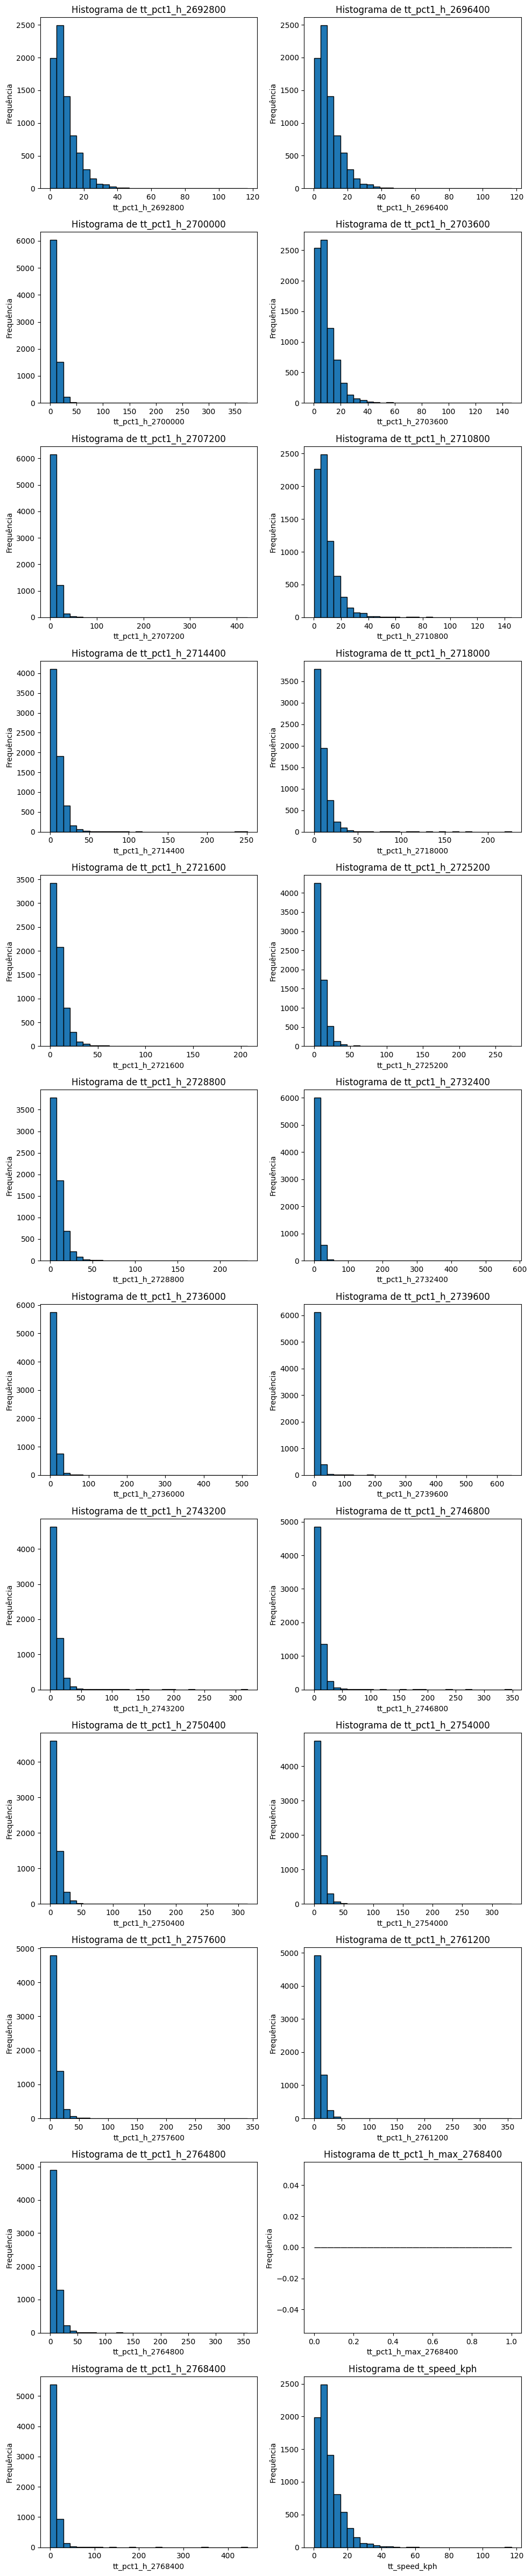

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Seleciona as colunas que começam com "tt" e a coluna "tt_speed_kph"
cols_interesse = [col for col in edges_baseline_reprojected.columns if col.startswith('tt')]

# Define o número de subplots; organizamos em 2 colunas
n_total = len(cols_interesse)
n_cols = 2
n_rows = math.ceil(n_total / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 4))

# Se houver apenas um subplot, encapsule-o em uma lista para facilitar a iteração
if n_total == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# Itera sobre as colunas e plota os histogramas
for i, col in enumerate(cols_interesse):
    # Remove os NaN e os valores infinitos para o histograma
    data = edges_baseline_reprojected[col].dropna()
    data = data[np.isfinite(data)]
    
    axes[i].hist(data, bins=30, edgecolor='black')
    axes[i].set_title(f'Histograma de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')

# Remove os eixos não utilizados, se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [21]:
# Verifique se as novas colunas foram adicionadas.
# Aqui estamos interessados em verificar se as colunas tt (Travel Time) foram
# adicionadas ao GDF
print(edges_baseline_reprojected.columns)

Index(['osmid', 'highway', 'lanes', 'maxspeed', 'oneway', 'reversed', 'length',
       'geometry', 'speed_kph', 'name', 'ref', 'junction', 'access', 'width',
       'bridge', 'pct1_h_2692800', 'pct1_h_2696400', 'pct1_h_2700000',
       'pct1_h_2703600', 'pct1_h_2707200', 'pct1_h_2710800', 'pct1_h_2714400',
       'pct1_h_2718000', 'pct1_h_2721600', 'pct1_h_2725200', 'pct1_h_2728800',
       'pct1_h_2732400', 'pct1_h_2736000', 'pct1_h_2739600', 'pct1_h_2743200',
       'pct1_h_2746800', 'pct1_h_2750400', 'pct1_h_2754000', 'pct1_h_2757600',
       'pct1_h_2761200', 'pct1_h_2764800', 'pct1_h_2768400_max',
       'pct1_h_2768400', 'tt_pct1_h_2692800', 'tt_pct1_h_2696400',
       'tt_pct1_h_2700000', 'tt_pct1_h_2703600', 'tt_pct1_h_2707200',
       'tt_pct1_h_2710800', 'tt_pct1_h_2714400', 'tt_pct1_h_2718000',
       'tt_pct1_h_2721600', 'tt_pct1_h_2725200', 'tt_pct1_h_2728800',
       'tt_pct1_h_2732400', 'tt_pct1_h_2736000', 'tt_pct1_h_2739600',
       'tt_pct1_h_2743200', 'tt_pct1_h_2746

#### Construir um novo grafo, com todas referências de velocidades

In [22]:
# Conta quantas vezes 99999 aparece na coluna identificada
num_99999 = (edges_baseline_reprojected['tt_pct1_h_2757600'] == np.inf).sum()

print(f"Número de ocorrências de infinito na coluna tt_pct1_h_2757600': {num_99999}")


Número de ocorrências de infinito na coluna tt_pct1_h_2757600': 1294


MultiDiGraph with 3136 nodes and 7874 edges


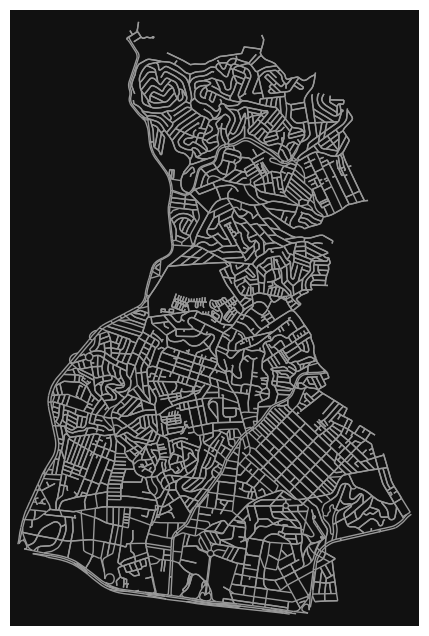

O sistema de referência de coordenadas do G_dinamico é: EPSG:31983


In [24]:
# Gerar o grafo e armazená-lo no dicionário
G_dinamico = ox.graph_from_gdfs(node_baseline, edges_simulados)

# Exibir o grafo
print(G_dinamico)
ox.plot_graph(G_dinamico)

# Verificar o sistema de referência de coordenadas
crs = G_dinamico.graph['crs']
print(f'O sistema de referência de coordenadas do G_dinamico é:', crs)

In [25]:
listar_atributos_arestas(G_dinamico)

{'access',
 'bridge',
 'geometry',
 'highway',
 'junction',
 'lanes',
 'length',
 'maxspeed',
 'name',
 'oneway',
 'osmid',
 'pct1_h_2692800',
 'pct1_h_2696400',
 'pct1_h_2700000',
 'pct1_h_2703600',
 'pct1_h_2707200',
 'pct1_h_2710800',
 'pct1_h_2714400',
 'pct1_h_2718000',
 'pct1_h_2721600',
 'pct1_h_2725200',
 'pct1_h_2728800',
 'pct1_h_2732400',
 'pct1_h_2736000',
 'pct1_h_2739600',
 'pct1_h_2743200',
 'pct1_h_2746800',
 'pct1_h_2750400',
 'pct1_h_2754000',
 'pct1_h_2757600',
 'pct1_h_2761200',
 'pct1_h_2764800',
 'pct1_h_2768400',
 'pct1_h_2768400_max',
 'pct1_h_max_2768400',
 'ref',
 'reversed',
 'speed_kph',
 'tt_pct1_h_2692800',
 'tt_pct1_h_2696400',
 'tt_pct1_h_2700000',
 'tt_pct1_h_2703600',
 'tt_pct1_h_2707200',
 'tt_pct1_h_2710800',
 'tt_pct1_h_2714400',
 'tt_pct1_h_2718000',
 'tt_pct1_h_2721600',
 'tt_pct1_h_2725200',
 'tt_pct1_h_2728800',
 'tt_pct1_h_2732400',
 'tt_pct1_h_2736000',
 'tt_pct1_h_2739600',
 'tt_pct1_h_2743200',
 'tt_pct1_h_2746800',
 'tt_pct1_h_2750400',
 't

In [ ]:
ox.save_graphml(G_dinamico, filepath='G_dinamico.graphml')

In [26]:
# Inicializa coluna_alvo para evitar NameError
coluna_alvo = None

# Percorre todas as arestas do grafo para encontrar um atributo que contenha "h_max"
for u, v, data in G_dinamico.edges(data=True):
    for atributo in data.keys():
        if "h_max" in atributo:
            coluna_alvo = atributo
            break  # Para ao encontrar a primeira ocorrência
    if coluna_alvo is not None:
        break

if coluna_alvo is None:
    raise ValueError("Nenhum atributo contendo 'h_max' foi encontrado nas arestas.")

# Obter todas as arestas com seus atributos (convertendo para array, se desejar)
dados_arestas = np.array([data.get(coluna_alvo, np.nan) for _, _, data in G_dinamico.edges(data=True)])

# Contar quantos valores são iguais a 99999
num_99999 = np.sum(dados_arestas == np.inf)
print(f"Número de valores infinito em '{coluna_alvo}': {num_99999}")

# Contar o número total de arestas
total_arestas = G_dinamico.number_of_edges()
print(f"Número total de arestas: {total_arestas}")


Número de valores infinito em 'pct1_h_max_2768400': 0
Número total de arestas: 7874


#### Cálculo do caminho mínimo

In [27]:
def pre_processar_grafo_star(G, referencia):
    """
    Pré-processa o grafo removendo arestas inválidas e identificando componentes conectados.
    """
    G_filtrado = G.copy()
    
    print("Número de arestas antes do pré-processamento:", len(G_filtrado.edges()))
   
    edges_remover = [(u, v, k) for u, v, k, d in G_filtrado.edges(keys=True, data=True) if referencia in d and d[referencia] == float('inf')]

    G_filtrado.remove_edges_from(edges_remover)
    
    # Manter apenas a componente fortemente conectada maior
    componentes = list(nx.strongly_connected_components(G_filtrado))
    maior_componente = max(componentes, key=len)
    G_filtrado = G_filtrado.subgraph(maior_componente).copy()
    
    # Plotargrafo
    #fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plota o grafo OSMnx no ax já criado
    #fig, ax = ox.plot_graph(
    #    G_filtrado, ax=ax, node_color='lightgray', node_size=10,
    #    edge_color='black', edge_alpha=0.5, show=False, close=False
    #)
    print("Número de arestas após pré-processamento:", len(G_filtrado.edges()))

    return G_filtrado

def heuristica_haversine(G, origem, destino):
    """
    Calcula a distância haversine entre dois nós do grafo.
    """
    lat1, lon1 = G.nodes[origem]['y'], G.nodes[origem]['x']
    lat2, lon2 = G.nodes[destino]['y'], G.nodes[destino]['x']
    return great_circle((lat1, lon1), (lat2, lon2)).meters

def caminho_minimo_star(G, origem, destino, peso):
    """
    Calcula o caminho mínimo entre dois nós no grafo pré-processado usando A*.
    """
    if not nx.has_path(G, origem, destino):
        return None, None
    
    try:
        caminho = nx.astar_path(G, source=origem, target=destino, weight=peso, heuristic=lambda u, v: heuristica_haversine(G, u, v))
        distancia = nx.astar_path_length(G, source=origem, target=destino, weight=peso, heuristic=lambda u, v: heuristica_haversine(G, u, v))
        return caminho, distancia
    except nx.NetworkXNoPath:
        return None, None

def calcula_caminho_minimo_star(gdf_OD, referencia_OD, G, referencia, sem_caminho=None):
    """
    Calcula caminhos mínimos entre pares de nós em um grafo OSMnx, considerando apenas vias transitáveis.
    """
    if sem_caminho is None:
        sem_caminho = set()
    
    G = pre_processar_grafo_star(G, referencia)  # Pré-processar grafo antes das buscas
    peso = referencia if any(referencia in d for _, _, d in G.edges(data=True)) else "length"
    
    nos_validos = set(G.nodes)  # Reduz buscas no grafo
    data_batch = []
    tempo_acumulado = 0 # Acumulador para o cálculo do tempo médio
    total_viagens = 0 # Contador de viagens
    start_time = time.time()
    
    for node1, node2 in itertools.combinations(gdf_OD[referencia_OD], 2):
        if node1 == node2 or (node1, node2) in sem_caminho or node1 not in nos_validos or node2 not in nos_validos:
            continue

        num_viagens = get_number_of_trips(node1, node2, referencia_OD, matriz_od_25)
        if num_viagens == 0:
            continue # Se não há viagens registradas, não processa
            
        caminho, tempo = caminho_minimo_star(G, node1, node2, peso)
        if caminho is not None:
            tempo_total = tempo * num_viagens  # Multiplica pelo número de viagens
            tempo_acumulado += tempo_total  # Acumula o tempo total
            total_viagens += num_viagens  # Acumula o número total de viagens
            
            data_batch.append({
                'Referência': referencia,
                'Origem': node1,
                'Destino': node2,
                'Tempo de viagem (min)': tempo / 60,
                'Número de viagens': num_viagens,
                'Tempo total ponderado (min)': tempo_total / 60,
                'Número de nós': len(caminho),
                'Percurso entre nós': list(caminho)
            })
        else:
            sem_caminho.add((node1, node2))

    tempo_medio = (tempo_acumulado / total_viagens) / 60 if total_viagens > 0 else None
    
    print(f"Tempo de processamento: {(time.time() - start_time) / 60:.2f} min")
    print(f'Viagens calculadas: {len(data_batch)}')
    print(f'Viagens sem conexão: {len(sem_caminho)}')
    print(f'Tempo médio de viagem ponderado: {tempo_medio:.2f} min' if tempo_medio else "Nenhuma viagem processada")
    
    return pd.DataFrame(data_batch), sem_caminho, tempo_medio


In [56]:
# Atualizações para incorporar o sem_caminho e otimizações de código
import time
import itertools
import pandas as pd

def calcula_caminho_minimo_star2(gdf_OD, referencia_OD, G, referencia, **kwargs):
    """
    Calcula caminhos mínimos entre pares de nós em um grafo OSMnx, considerando apenas vias transitáveis.
    Otimizado para rodar em grande escala.
    """
    sem_caminho = kwargs.get('sem_caminho_chuva', None)
    if sem_caminho is None:
        sem_caminho = set()
        #print(f'{blue}Sem_caminho veio vazio! {reset}')
    else:
        # Se for inteiro, transforme em conjunto vazio
        #print(f'{blue}Opa! Sem_caminho veio com alguma coisa! {reset} {len(sem_caminho)}')
        if not isinstance(sem_caminho, (list, set, tuple)):
            sem_caminho = set()

        sem_caminho = set(tuple(pair) for pair in sem_caminho)  # Garante que a estrutura é um conjunto de tuplas

    G = pre_processar_grafo_star(G, referencia)  # Pré-processa o grafo
    peso = referencia if any(referencia in d for _, _, d in G.edges(data=True)) else "length"
    print(f'A referência utilizada é: ',referencia)
    print(f'A referência OD utilizada é: ',referencia_OD)

    nos_validos = set(G.nodes)  # Evita buscas repetitivas no grafo
    #print(f'Nós validos: ',nos_validos)
    data_batch = []
    tempo_acumulado = 0
    total_viagens = 0
    start_time = time.time()

    # Pré-calcula número de viagens entre pares
    matriz_od = { (n1, n2): get_number_of_trips(n1, n2, referencia_OD, matriz_od_25) 
                  for n1, n2 in itertools.permutations(gdf_OD[referencia_OD], 2) 
                  if (n1, n2) not in sem_caminho and n1 in nos_validos and n2 in nos_validos }
    #print(f'A matriz OD é: ',matriz_od)

    for (node1, node2), num_viagens in matriz_od.items():
        #print('Começando os cálculos dos tempos de viagem')
        if num_viagens == 0:
            continue  # Ignora pares sem viagens registradas
        
        caminho, tempo = caminho_minimo_star(G, node1, node2, peso)
        if caminho is not None:
            tempo_total = tempo * num_viagens
            tempo_acumulado += tempo_total
            total_viagens += num_viagens

            data_batch.append({
                'Referência': referencia,
                'Origem': node1,
                'Destino': node2,
                'Tempo de viagem (min)': tempo / 60,
                'Número de viagens': num_viagens,
                'Tempo total ponderado (min)': tempo_total / 60,
                'Número de nós': len(caminho),
                'Percurso entre nós': list(caminho)
            })
        else:
            print(f'Sem caminho antes: {sem_caminho}')
            sem_caminho.add((node1, node2))
            print(f'Sem caminho depois: {sem_caminho}')

    tempo_medio = (tempo_acumulado / total_viagens) / 60 if total_viagens > 0 else None

    print(f"Tempo de processamento: {(time.time() - start_time) / 60:.2f} min")
    print(f'Viagens calculadas: {len(data_batch)}')
    print(f'Viagens sem conexão: {blue}{len(sem_caminho)}{reset}')
    print(f'Tempo médio de viagem ponderado: {blue} {tempo_medio:.2f} min {reset}' if tempo_medio else "Nenhuma viagem processada")

    return pd.DataFrame(data_batch), sem_caminho, tempo_medio


In [59]:
atributos_tt = set()
    
for _, _, dados in G_dinamico.edges(data=True):
    for atributo in dados.keys():
        if atributo.startswith("tt"):
            atributos_tt.add(atributo)

atributos_tt = [linha for linha in atributos_tt if "speed"not in linha]

#Ordenar a lista pelo número extraído
atributos_tt_ord = sorted(atributos_tt, key=extrair_numero)

# Exibir a lista ordenada
for arquivo in atributos_tt_ord:
    print(arquivo)

# Limitando o tamanho da lista para facilitar o debug
#atributos_tt_ord = atributos_tt_ord[6:7]
print(atributos_tt_ord)

tt_pct1_h_2692800
tt_pct1_h_2696400
tt_pct1_h_2700000
tt_pct1_h_2703600
tt_pct1_h_2707200
tt_pct1_h_2710800
tt_pct1_h_2714400
tt_pct1_h_2718000
tt_pct1_h_2721600
tt_pct1_h_2725200
tt_pct1_h_2728800
tt_pct1_h_2732400
tt_pct1_h_2736000
tt_pct1_h_2739600
tt_pct1_h_2743200
tt_pct1_h_2746800
tt_pct1_h_2750400
tt_pct1_h_2754000
tt_pct1_h_2757600
tt_pct1_h_2761200
tt_pct1_h_2764800
tt_pct1_h_2768400
tt_pct1_h_max_2768400
['tt_pct1_h_2692800', 'tt_pct1_h_2696400', 'tt_pct1_h_2700000', 'tt_pct1_h_2703600', 'tt_pct1_h_2707200', 'tt_pct1_h_2710800', 'tt_pct1_h_2714400', 'tt_pct1_h_2718000', 'tt_pct1_h_2721600', 'tt_pct1_h_2725200', 'tt_pct1_h_2728800', 'tt_pct1_h_2732400', 'tt_pct1_h_2736000', 'tt_pct1_h_2739600', 'tt_pct1_h_2743200', 'tt_pct1_h_2746800', 'tt_pct1_h_2750400', 'tt_pct1_h_2754000', 'tt_pct1_h_2757600', 'tt_pct1_h_2761200', 'tt_pct1_h_2764800', 'tt_pct1_h_2768400', 'tt_pct1_h_max_2768400']


In [30]:
listar_atributos_arestas(G_dinamico)

{'access',
 'bridge',
 'geometry',
 'highway',
 'junction',
 'lanes',
 'length',
 'maxspeed',
 'name',
 'oneway',
 'osmid',
 'pct1_h_2692800',
 'pct1_h_2696400',
 'pct1_h_2700000',
 'pct1_h_2703600',
 'pct1_h_2707200',
 'pct1_h_2710800',
 'pct1_h_2714400',
 'pct1_h_2718000',
 'pct1_h_2721600',
 'pct1_h_2725200',
 'pct1_h_2728800',
 'pct1_h_2732400',
 'pct1_h_2736000',
 'pct1_h_2739600',
 'pct1_h_2743200',
 'pct1_h_2746800',
 'pct1_h_2750400',
 'pct1_h_2754000',
 'pct1_h_2757600',
 'pct1_h_2761200',
 'pct1_h_2764800',
 'pct1_h_2768400',
 'pct1_h_2768400_max',
 'pct1_h_max_2768400',
 'ref',
 'reversed',
 'speed_kph',
 'tt_pct1_h_2692800',
 'tt_pct1_h_2696400',
 'tt_pct1_h_2700000',
 'tt_pct1_h_2703600',
 'tt_pct1_h_2707200',
 'tt_pct1_h_2710800',
 'tt_pct1_h_2714400',
 'tt_pct1_h_2718000',
 'tt_pct1_h_2721600',
 'tt_pct1_h_2725200',
 'tt_pct1_h_2728800',
 'tt_pct1_h_2732400',
 'tt_pct1_h_2736000',
 'tt_pct1_h_2739600',
 'tt_pct1_h_2743200',
 'tt_pct1_h_2746800',
 'tt_pct1_h_2750400',
 't

In [53]:
# Função auxiliar para calcular tempos de viagem
def calcular_tempo_viagem(gdf, referencia, coluna_peso, grafo, sem_caminho_chuva=None):
    # Prepara os parâmetros extras para a função auxiliar, se necessário
    extra_params = {}
    if sem_caminho_chuva is not None:
        extra_params['sem_caminho_chuva'] = sem_caminho_chuva

    inicio = time.time()
    tempos, sem_caminho, tempo_medio = calcula_caminho_minimo_star2(gdf, referencia, grafo, coluna_peso, **extra_params)
    tempo_execucao = time.time() - inicio

    #print(f'{blue}Tamanho de sem_caminho: {len(sem_caminho)}{reset}')
    
    return tempo_medio, sem_caminho, len(sem_caminho), tempo_execucao

In [38]:
# Se no código original você usou replace(' ', '_'), faça o mesmo aqui:
subpref_underscored = nome_sp.replace(' ', '_')

# Supondo que o padrão seja "nearest_node_" + subpref_underscored
coluna_desejada = f"nearest_node_{subpref_underscored}"

print("Coluna construída dinamicamente:", coluna_desejada)

# Verifique se essa coluna existe no seu GDF:
if coluna_desejada in gdf_nos_aproximados.columns:
    print(f"A coluna '{coluna_desejada}' existe!\n")
else:
    print(f"A coluna '{coluna_desejada}' não foi encontrada no GDF.\n")

# Verifica se coluna faz parte dos atributos das arestas de G_dinamico
for u, v, data in G_dinamico.edges(data=True):
    if coluna not in data:
        print(f"Aresta {u} - {v} NÃO possui o atributo ", coluna)

Coluna construída dinamicamente: nearest_node_CASA_VERDE-CACHOEIRINHA
A coluna 'nearest_node_CASA_VERDE-CACHOEIRINHA' existe!



In [60]:
# Inicializa a lista de resultados
resultados = []

# Loop sobre os atributos
for coluna in tqdm(atributos_tt_ord, desc="Processando atributos", unit='atributo'):
    print(f'\nIniciando o cálculo para a referência: {coluna}')
      
    # 1. Cálculo com chuva
    print(f'Calculando tempo de viagem {blue} COM CHUVA...{reset}')
    print('Nearest node baseline: ',coluna_desejada)
    print('Referência: ',coluna)
    tt_chuva, sem_caminho_chuva, viagens_ignoradas_chuva, tempo_execucao_chuva = calcular_tempo_viagem(
    gdf_nos_aproximados, coluna_desejada, coluna, G_dinamico
    )

    # 2. Cálculo sem chuva, modificado
    print(f'Calculando tempo de viagem {blue} SEM CHUVA, MODIFICADO...{reset}')
    tt_seco_mod, _, viagens_ignoradas_mod, tempo_execucao_mod = calcular_tempo_viagem(
    gdf_nos_aproximados, coluna_desejada, 'tt_speed_kph', G_dinamico, sem_caminho_chuva
    )

    # Adiciona os resultados à lista
    resultados.append({
        'coluna': coluna,
        'tt_chuva': tt_chuva,
        'tt_seco_mod': tt_seco_mod,
        'viagens_ignoradas_chuva': viagens_ignoradas_chuva,
        'viagens_ignoradas_mod': viagens_ignoradas_mod,
        'tempo_execucao_chuva': tempo_execucao_chuva,
        'tempo_execucao_mod': tempo_execucao_mod
    })

# Converte os resultados para um DataFrame
df_resultados_resiliencia = pd.DataFrame(resultados)

Processando atributos:   0%|          | 0/23 [00:00<?, ?atributo/s]


Iniciando o cálculo para a referência: tt_pct1_h_2692800
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2692800
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_pct1_h_2692800
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874


Processando atributos:   4%|▍         | 1/23 [00:01<00:31,  1.42s/atributo]

Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2696400
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2696400
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 7815
A referência utilizada é:  tt_pct1_h_2696400
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874


Processando atributos:   9%|▊         | 2/23 [00:02<00:30,  1.47s/atributo]

Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2700000
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2700000
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 7731
A referência utilizada é:  tt_pct1_h_2700000
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874


Processando atributos:  13%|█▎        | 3/23 [00:03<00:24,  1.25s/atributo]

Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2703600
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2703600
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 7614
A referência utilizada é:  tt_pct1_h_2703600
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.08 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referê

Processando atributos:  17%|█▋        | 4/23 [00:05<00:24,  1.31s/atributo]

Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2707200
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2707200
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 7471
A referência utilizada é:  tt_pct1_h_2707200
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.10 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874


Processando atributos:  22%|██▏       | 5/23 [00:06<00:24,  1.36s/atributo]

Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2710800
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2710800
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 7048
A referência utilizada é:  tt_pct1_h_2710800
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.57 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referê

Processando atributos:  26%|██▌       | 6/23 [00:07<00:20,  1.22s/atributo]

Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2714400
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2714400
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 6799
A referência utilizada é:  tt_pct1_h_2714400
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  7.21 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA


Processando atributos:  30%|███       | 7/23 [00:08<00:19,  1.24s/atributo]

Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2718000
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2718000
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 6729
A referência utilizada é:  tt_pct1_h_2718000
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.71 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874


Processando atributos:  35%|███▍      | 8/23 [00:10<00:19,  1.31s/atributo]

Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2721600
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2721600
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 6669
A referência utilizada é:  tt_pct1_h_2721600
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.80 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referê

Processando atributos:  39%|███▉      | 9/23 [00:11<00:16,  1.19s/atributo]

Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2725200
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2725200
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 6651
A referência utilizada é:  tt_pct1_h_2725200
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.86 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA


Processando atributos:  43%|████▎     | 10/23 [00:12<00:16,  1.24s/atributo]

Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2728800
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2728800
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 6622
A referência utilizada é:  tt_pct1_h_2728800
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.92 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874


Processando atributos:  48%|████▊     | 11/23 [00:13<00:13,  1.13s/atributo]

Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2732400
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2732400
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 6581
A referência utilizada é:  tt_pct1_h_2732400
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  7.18 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874


Processando atributos:  52%|█████▏    | 12/23 [00:15<00:13,  1.22s/atributo]

Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.01 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2736000
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2736000
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 6556
A referência utilizada é:  tt_pct1_h_2736000
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  7.37 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874


Processando atributos:  57%|█████▋    | 13/23 [00:16<00:12,  1.24s/atributo]

Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2739600
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2739600
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 6533
A referência utilizada é:  tt_pct1_h_2739600
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  7.69 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874


Processando atributos:  61%|██████    | 14/23 [00:17<00:10,  1.14s/atributo]

Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2743200
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2743200
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 6521
A referência utilizada é:  tt_pct1_h_2743200
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  7.46 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874


Processando atributos:  65%|██████▌   | 15/23 [00:18<00:09,  1.18s/atributo]

Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2746800
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2746800
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 6517
A referência utilizada é:  tt_pct1_h_2746800
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  7.32 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874


Processando atributos:  70%|██████▉   | 16/23 [00:19<00:08,  1.22s/atributo]

Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2750400
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2750400
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 6503
A referência utilizada é:  tt_pct1_h_2750400
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  7.34 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874


Processando atributos:  74%|███████▍  | 17/23 [00:20<00:06,  1.16s/atributo]

Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2754000
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2754000
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 6504
A referência utilizada é:  tt_pct1_h_2754000
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  7.20 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referê

Processando atributos:  78%|███████▊  | 18/23 [00:22<00:06,  1.22s/atributo]

Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2757600
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2757600
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 6514
A referência utilizada é:  tt_pct1_h_2757600
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  7.12 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874


Processando atributos:  83%|████████▎ | 19/23 [00:23<00:04,  1.24s/atributo]

Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2761200
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2761200
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 6498
A referência utilizada é:  tt_pct1_h_2761200
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  7.05 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874


Processando atributos:  87%|████████▋ | 20/23 [00:24<00:03,  1.14s/atributo]

Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2764800
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2764800
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 6468
A referência utilizada é:  tt_pct1_h_2764800
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  7.57 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referê

Processando atributos:  91%|█████████▏| 21/23 [00:25<00:02,  1.22s/atributo]

Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_2768400
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_2768400
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 6459
A referência utilizada é:  tt_pct1_h_2768400
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.01 min
Viagens calculadas: 21
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  7.74 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874


Processando atributos:  96%|█████████▌| 22/23 [00:26<00:01,  1.19s/atributo]

Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 

Iniciando o cálculo para a referência: tt_pct1_h_max_2768400
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Referência:  tt_pct1_h_max_2768400
Número de arestas antes do pré-processamento: 7874
Número de arestas após pré-processamento: 0
A referência utilizada é:  tt_pct1_h_max_2768400
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 0
Viagens sem conexão: 0
Nenhuma viagem processada
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
Número de arestas antes do pré-processamento: 7874


Processando atributos: 100%|██████████| 23/23 [00:27<00:00,  1.22s/atributo]

Número de arestas após pré-processamento: 7817
A referência utilizada é:  tt_speed_kph
A referência OD utilizada é:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conexão: 0
Tempo médio de viagem ponderado:  6.06 min 


#### Montar o histograma

In [40]:
df_resultados_resiliencia

# Remover a linha que contém "max" na coluna 'Hora Simulada'
resiliencia_df = df_resultados_resiliencia[~df_resultados_resiliencia['coluna'].str.contains('max', na=False)]

# Extrair o número após "h_" e converter para inteiro para ordenação
#resiliencia_df['h_value'] = resiliencia_df['Hora Simulada'].str.extract(r'h_(\d+)').astype(float)

# Ordenar o DataFrame pelo valor numérico extraído
resiliencia_df = resiliencia_df.sort_values(by='coluna', ascending=True)

# Resetar o índice após a ordenação
resiliencia_df = resiliencia_df.reset_index(drop=True)

# Exibir o DataFrame transformado
print(resiliencia_df)

               coluna  tt_chuva  tt_seco_mod  viagens_ignoradas_chuva  \
0   tt_pct1_h_2692800  6.057434     6.057434                        0   
1   tt_pct1_h_2696400  6.057434     6.057434                        0   
2   tt_pct1_h_2700000  6.058130     6.057434                        0   
3   tt_pct1_h_2703600  6.082920     6.057434                        0   
4   tt_pct1_h_2707200  6.101866     6.057434                        0   
5   tt_pct1_h_2710800  6.565236     6.057434                        0   
6   tt_pct1_h_2714400  7.207443     6.057434                        0   
7   tt_pct1_h_2718000  6.707783     6.057434                        0   
8   tt_pct1_h_2721600  6.804966     6.057434                        0   
9   tt_pct1_h_2725200  6.856428     6.057434                        0   
10  tt_pct1_h_2728800  6.924401     6.057434                        0   
11  tt_pct1_h_2732400  7.179616     6.057434                        0   
12  tt_pct1_h_2736000  7.367494     6.057434       

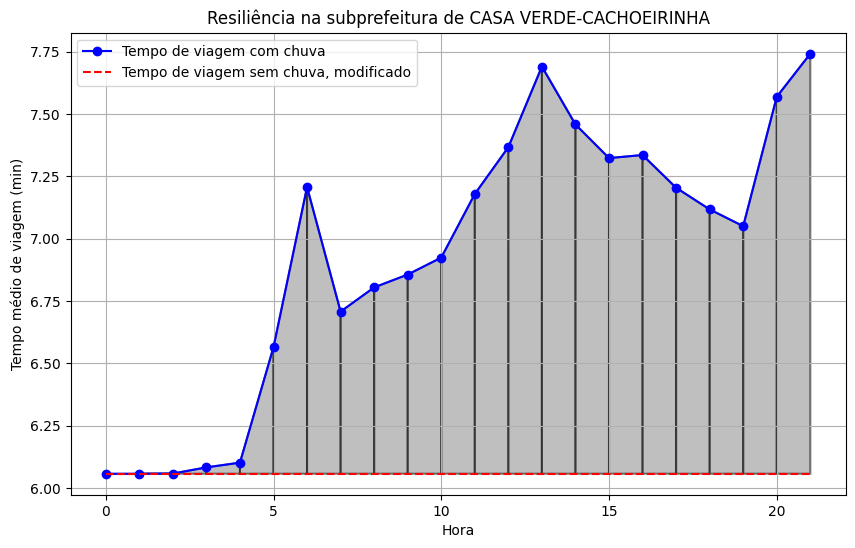

A resiliência (área total sob a curva): 18.36 


In [61]:
# Definir baseline como 'TT sem chuva, modificado'
baseline = resiliencia_df['tt_seco_mod'].min()
area_total = 0

# Criar figura
plt.figure(figsize=(10, 6))

# Criar índices para plotagem
x = np.arange(len(resiliencia_df))
y = resiliencia_df['tt_chuva'].values
baseline_values = resiliencia_df['tt_seco_mod'].values

# Plotar linha de TT com chuva
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Tempo de viagem com chuva')

# Adicionar linha de baseline
plt.plot(x, baseline_values, linestyle='--', color='r', label='Tempo de viagem sem chuva, modificado')

# Preencher trapézios entre baseline e TT com chuva
for i in range(len(x) - 1):
    x_trapezoid = [x[i], x[i], x[i+1], x[i+1]]
    y_trapezoid = [baseline_values[i], y[i], y[i+1], baseline_values[i]]

    # Preencher o trapézio
    plt.fill(x_trapezoid, y_trapezoid, 'gray', alpha=0.5, edgecolor='k', linewidth=1.5)

    # Calcular a área do trapézio
    base1 = abs(y[i] - baseline_values[i])
    base2 = abs(y[i+1] - baseline_values[i+1])
    altura = 1  # Como o eixo X é discreto, altura = 1 unidade
    area_trap = 0.5 * (base1 + base2) * altura
    area_total += area_trap

# Ajustes do gráfico
plt.xlabel('Hora')
plt.ylabel('Tempo médio de viagem (min)')
plt.title('Resiliência na subprefeitura de ' + nome_sp)
plt.legend()
plt.grid(True)

# Exibir gráfico
plt.show()

# Exibir área total sob a curva
print(f"A resiliência (área total sob a curva): {area_total:.2f} ")

#### Obtenção da informação de chuva

In [ ]:
#arquivo_chuva = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estações_meteorológicas/meteorologicas_2023/dados_cge___P400_Riacho_Grande.csv'

diretório_chuva = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estações_meteorológicas/meteorologicas_2023'

In [64]:
# Indicador numérico dos postos:
postos = [503, 1000866, 495, 1000840, 1000854, 1000850, 1000852, 634, 592, 846, 507, 1000300, 1000860, 1000887, 1000859, 524, 1000864, 1000844, 1000862, 1000882, 1000635, 1000842, 1000848, 504, 515, 509, 1000944, 540, 510, 400, 1000876]

# Dados fornecidos (reutilizados):
names = [
    "Sé - CGE (PMSP/SE-01)", "Sé - Anhembi (PMSP/SE-02)", "Vila Mariana (PMSP/VM-01)", 
    "Ipiranga (PMSP/IP-01)", "Campo Limpo (PMSP/CL-03)", "M Boi Mirim (PMSP/MB-01)", 
    "Santo Amaro (PMSP/SA-01)", "Jabaquara (PMSP/JA-01)", "Cidade Ademar - (PMSP/AD-01) / São Paulo", 
    "Capela do Socorro (PMSP/CS-01)", "Parelheiros - Barragem (PMSP/PA-01)", 
    "Estação Meteorológica Marsilac", "Mooca (PMSP/MO-01)", "Penha - Rincão (PMSP/PE-01)", 
    "Aricanduva - Vila Formosa (PMSP/AF-02)", "Vila Prudente - (PMSP/VP-01)", "Itaquera (PMSP/IQ-02)", 
    "São Mateus (PMSP/SM-05)", "São Miguel Paulista (PMSP/MP-01)", "Itaim Paulista (PMSP/IT-01)", 
    "Pinheiros (PMSP/PI-01)", "Butantã (PMSP/BT-02)", "Lapa (PMSP/LA-01)", "Perus (PMSP/PR-01)", 
    "Pirituba (PMSP/PJ-01)", "Freguesia do Ó (PMSP/FO-01)", "Tremembé (PMSP/JT-01)", 
    "Vila Maria - Vila Guilherme (PMSP/MG-01)", "Santana/Tucuruvi - COMDEC (PMSP/ST-01)", 
    "Riacho Grande", "Mauá - Paço Municipal"
]

# Exemplo de lista adicional de estações:
estacoes = ['0', '1', '2', '3', '4', '5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','30','31']

# Índices
indices = list(range(len(names)))

# Criar dicionário com o formato {index: {name, estacao, posto}}
dicionario_estacoes = {
    i: {'Name': names[i], 'Estacao': estacoes[i], 'Posto': postos[i]} 
    for i in indices
}

# Exibir o dicionário
dicionario_estacoes

{0: {'Name': 'Sé - CGE (PMSP/SE-01)', 'Estacao': '0', 'Posto': 503},
 1: {'Name': 'Sé - Anhembi (PMSP/SE-02)', 'Estacao': '1', 'Posto': 1000866},
 2: {'Name': 'Vila Mariana (PMSP/VM-01)', 'Estacao': '2', 'Posto': 495},
 3: {'Name': 'Ipiranga (PMSP/IP-01)', 'Estacao': '3', 'Posto': 1000840},
 4: {'Name': 'Campo Limpo (PMSP/CL-03)', 'Estacao': '4', 'Posto': 1000854},
 5: {'Name': 'M Boi Mirim (PMSP/MB-01)', 'Estacao': '5', 'Posto': 1000850},
 6: {'Name': 'Santo Amaro (PMSP/SA-01)', 'Estacao': '6', 'Posto': 1000852},
 7: {'Name': 'Jabaquara (PMSP/JA-01)', 'Estacao': '7', 'Posto': 634},
 8: {'Name': 'Cidade Ademar - (PMSP/AD-01) / São Paulo',
  'Estacao': '8',
  'Posto': 592},
 9: {'Name': 'Capela do Socorro (PMSP/CS-01)', 'Estacao': '9', 'Posto': 846},
 10: {'Name': 'Parelheiros - Barragem (PMSP/PA-01)',
  'Estacao': '10',
  'Posto': 507},
 11: {'Name': 'Estação Meteorológica Marsilac',
  'Estacao': '11',
  'Posto': 1000300},
 12: {'Name': 'Mooca (PMSP/MO-01)', 'Estacao': '12', 'Posto': 1

In [65]:
def listar_csv_chuva(diretorio):
    arquivos_csv = []
    
    # Percorre os arquivos no diretório fornecido
    for arquivo in os.listdir(diretorio):
        # Verifica se o arquivo tem extensão .csv
        # Reparar que os dados estão filtrados
        if arquivo.endswith(".csv"):
            arquivos_csv.append(arquivo)
                
    return arquivos_csv
    
def buscar_estacao_por_posto(dicionario, posto_desejado):
    for info in dicionario.values():
        if info['Posto'] == posto_desejado:
            return info['Estacao']
        else:
            print(f'O posto {posto_desejado} não foi encontrado')
    return "Posto não encontrado"

In [69]:
import os
import pandas as pd
from glob import glob

# Função para processar um único arquivo CSV
def processar_arquivo_chuva(arquivo_chuva):
    # Carregar o CSV
    df_chuva_10min = pd.read_csv(arquivo_chuva, sep=',')
    
    # Verificar se o DataFrame não está vazio
    if df_chuva_10min.empty:
        print(f"Arquivo {arquivo_chuva} está vazio. Pulando.")
        return None
    
    # Selecionar as colunas relevantes
    df_chuva_10min = df_chuva_10min.loc[:, ['DATA', 'Posto', 'PLU(mm)']]
    
    # Converter os valores da coluna 'PLU(mm)' de mm/h para m/h
    #df_chuva_10min = converter_mm_para_m(df_chuva_10min, 'PLU(mm)')

    # Converter a coluna 'DATA' para datetime
    df_chuva_10min['DATA'] = pd.to_datetime(df_chuva_10min['DATA'])
    
    # Filtrar pelos meses desejados 
    meses_desejados = [1, 2, 3]  # Janeiro, Fevereiro e Março
    df_chuva_10min = df_chuva_10min[df_chuva_10min['DATA'].dt.month.isin(meses_desejados)]
    
     # Verificar se o DataFrame ainda contém dados após o filtro
    if df_chuva_10min.empty:
        print(f"Nenhum dado relevante nos meses desejados no arquivo {arquivo_chuva}. Pulando.")
        return None
    
    # Definir a coluna 'DATA' como índice
    df_chuva_10min.set_index('DATA', inplace=True)
    
    # Somar os valores de 'PLU(mm)' a cada hora e criar um novo DataFrame com os dados agregados
    df_chuva_hora = df_chuva_10min['PLU(mm)'].resample('h').sum().to_frame()
    
    # Capturar o número do posto (assumindo que é o mesmo para todas as linhas)
    numero_posto = df_chuva_10min['Posto'].iloc[0]
    if numero_posto == 400:
        print('Achei um dos perdidos! ', numero_posto)
        
    # Excluir a coluna 'Posto'
    df_chuva_10min.drop(columns=['Posto'], inplace=True)
    
    # Renomear a coluna 'PLU(mm)' para incluir o número do posto
    estacao = buscar_estacao_por_posto(dicionario_estacoes, numero_posto)
    df_chuva_hora.rename(columns={'PLU(mm)': estacao}, inplace=True)
    
    # Criar novas colunas 'Dia' e 'Hora' com base no índice
    df_chuva_hora['Dia'] = df_chuva_hora.index.date
    df_chuva_hora['Hora'] = df_chuva_hora.index.time
    
    return df_chuva_hora
    
def converter_mm_para_m(df, nome_coluna):
    # De acordo com as informações encontradas no tutorial do SynxFlow, os dados de chuva
    # deverão ser inseridos como m/h: 
    # https://synxflow.readthedocs.io/en/latest/Tutorials/flood.html
    # The other columns are the rainfall intensity values (in meter per second) for cells with rain mask indices starting from 0
    # Verificar se a coluna existe no DataFrame
    if nome_coluna in df.columns:
        # Converter os valores de mm/h para m/h
        df[nome_coluna] = df[nome_coluna] / 1000
        # Não tenho certeza, mas me parece ser necessário dividir por 3600, passando de segundo para hora:
        df[nome_coluna] = df[nome_coluna] / 3600
    else:
        print(f"Coluna '{nome_coluna}' não encontrada no DataFrame.")
    
    return df

In [67]:
# Função para processar todos os arquivos CSV em um diretório
def processar_todos_arquivos_chuva(diretorio):
    # Encontrar todos os arquivos CSV no diretório
    arquivos_csv = glob(os.path.join(diretorio, '*.csv'))
    
    # Criar uma lista para armazenar os DataFrames processados
    dfs_processados = []
    
    # Iterar sobre todos os arquivos CSV
    for arquivo in arquivos_csv:
        print(f"Processando {arquivo}...")
        df_processado = processar_arquivo_chuva(arquivo)
        if df_processado is not None:
            dfs_processados.append(df_processado)
    
    # Concatenar todos os DataFrames processados (usando join para garantir alinhamento por 'DATA')
    df_final = pd.concat(dfs_processados, axis=1, join='outer')
    
    # Remover possíveis duplicatas no índice
    df_final = df_final[~df_final.index.duplicated(keep='first')]
    
    # Remover colunas desnecessárias (mantendo apenas 'DATA' e os valores de PLU)
    colunas_a_remover = [col for col in df_final.columns if 'Dia' in col or 'Hora' in col]
    df_final = df_final.drop(columns=colunas_a_remover)
    
    # Identificar a primeira coluna como coluna de data, assumindo que seja a primeira coluna do DataFrame
    primeira_coluna = df_final.columns[0]  # Obtenha o nome da primeira coluna

    # Excluir colunas com o título 'Posto não encontrado'
    df_final = df_final.loc[:, ~df_final.columns.str.contains('Posto não encontrado')]

    # Adiciona uma coluna 1 com valores zerados
    df_final.loc[:,'1'] = 0

    # Adiciona uma coluna 29 com valores zerados, já que esse pluviometro está localizado em Santana do Parnaíba (fora dos limites do munícipio de São Paulo)
    df_final.loc[:,'29'] = 0

    # Ordenar as colunas numéricas em ordem crescente
    colunas_numericas = sorted([col for col in df_final.columns if col.isnumeric()], key=int)

    # Verificar se a primeira coluna é de datas ou texto e organizar a ordem
    if primeira_coluna not in colunas_numericas:
        # Colocar a primeira coluna (DATA) antes das colunas numéricas ordenadas
        df_final = df_final[[primeira_coluna] + colunas_numericas]
    else:
        # Caso contrário, apenas reordena as colunas numéricas
        df_final = df_final[colunas_numericas]

    df_final = adicionar_indexador(df_final)
    
    # Pegando todas as colunas do DataFrame
    colunas = df_final.columns.tolist()
    
    # Movendo a coluna 'indexador' para ser a segunda
    colunas.remove('indexador')
    nova_ordem = ['indexador'] + colunas

    # Reordenando o DataFrame
    df_final = df_final[nova_ordem]

    return df_final

In [71]:
def adicionar_indexador(df):
    # Cria uma coluna 'indexador' começando em 0 e incrementando 3600 a cada linha
    df['indexador'] = range(0, len(df) * 3600, 3600)
    return df

In [72]:
df_final_2023 = processar_todos_arquivos_chuva(diretório_chuva)

# Verificar as primeiras linhas do DataFrame final
df_final_2023

Processando /Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estações_meteorológicas/meteorologicas_2023/dados_cge___P524_Vila_Prudente____PMSP_VP_01_.csv...
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
Processando /Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estações_meteorológicas/mete

,indexador,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
DATA,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,0,2.256,0,4.700,0.564,3.384,0.940,124.340,118.046,0.000,...,4.512,1.692,123.665,0.752,0.0,117.744,2.820,0,0.376,0.0
2023-01-01 01:00:00,3600,1.504,0,6.768,0.000,2.256,1.692,122.961,116.223,0.000,...,3.384,0.188,121.983,0.000,0.0,118.610,5.828,0,0.752,0.0
2023-01-01 02:00:00,7200,3.948,0,7.520,0.000,2.444,2.444,122.457,117.503,0.376,...,1.692,0.564,123.242,0.188,0.0,119.123,1.316,0,0.752,0.0
2023-01-01 03:00:00,10800,4.136,0,10.152,0.000,2.444,3.196,122.235,118.328,3.008,...,4.888,0.000,120.021,0.000,0.0,116.959,7.708,0,1.880,0.0
2023-01-01 04:00:00,14400,0.940,0,7.144,1.504,2.444,0.940,120.573,114.943,0.000,...,2.068,0.000,117.039,0.000,0.0,113.112,4.136,0,4.888,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 19:00:00,7758000,0.000,0,3.008,0.000,1.316,4.136,134.623,130.996,3.384,...,5.264,5.452,134.482,0.000,0.0,122.477,3.384,0,0.752,0.0
2023-03-31 20:00:00,7761600,2.256,0,2.632,0.000,1.692,0.000,136.850,132.982,0.000,...,5.640,1.128,141.572,0.000,0.0,125.730,9.588,0,1.316,0.0
2023-03-31 21:00:00,7765200,2.820,0,3.008,0.000,3.760,2.444,135.096,128.561,1.316,...,3.384,2.444,136.527,0.000,0.0,124.823,9.024,0,0.000,0.0


#### Alinhamento com o pacote sendo processado

In [76]:
pacotes = '/Users/marcelofernandes/PycharmProjects/SP_urban_flooding/pacotes.simul_2023_1120.xls'

pacote_num

'Pacote_01'

In [92]:
# Carregar o arquivo Excel
df_pacotes = pd.read_excel(pacotes)

# Exibir as primeiras linhas para entender a estrutura dos dados (opcional)
#print(df_pacotes.head())

# Usando expressão regular para extrair apenas os números
numero_extraido = re.search(r'\d+', pacote_num).group()

# Convertendo diretamente para float (remove zeros à esquerda e adiciona ".0")
numero_com_ponto = float(int(numero_extraido))

# Localize a linha que corresponde ao pacote_num (supondo que há uma coluna chamada 'pacote_num')
linha_pacote = df_pacotes[df_pacotes['Pacote'] == numero_com_ponto]

# Verifique se a linha foi encontrada
if not linha_pacote.empty:
    # Supondo que as colunas de hora inicial e final são 'hora_inicial' e 'hora_final'
    hora_inicial = linha_pacote['Simulação Início'].values[0]
    hora_final = linha_pacote['Simulação Final'].values[0]
    print(f'Hora inicial da simulação: {hora_inicial}')
    print(f'Hora final da simulação: {hora_final}')
    data_inicial = linha_pacote['Data_Simul_Ini'].values[0]
    data_final = linha_pacote['Data_Simul_Fim'].values[0]
    print(f'Data inicial da simulação: {data_inicial}')
    print(f'Data final da simulação: {data_final}')
else:
    print(f'Pacote número {numero_com_ponto} não encontrado no arquivo.')


Hora inicial da simulação: 04:25:00
Hora final da simulação: 00:31:00
Data inicial da simulação: 2023-02-01T00:00:00.000000000
Data final da simulação: 2023-02-02T00:00:00.000000000


In [98]:
from datetime import datetime, timedelta

# Datas base
data_inicial = datetime.fromisoformat("2023-02-01T00:00:00")
data_final = datetime.fromisoformat("2023-02-02T00:00:00")

# Horas como timedelta (certo!)
hora_inicial = timedelta(hours=4, minutes=25)   # 04:25:00
hora_final = timedelta(hours=0, minutes=31)     # 00:31:00

# Combinação correta (datetime + timedelta)
inicio_simulacao = data_inicial + hora_inicial
fim_simulacao = data_final + hora_final

# Gerar o intervalo completo entre data + hora inicial e final
inicio_simulacao = data_inicial + hora_inicial
fim_simulacao = data_final + hora_final

# Filtrar o DataFrame com base nesse intervalo
df_filtrado = df_final_2023.loc[(df_final_2023.index >= inicio_simulacao) & (df_final_2023.index <= fim_simulacao)]

df_filtrado


,indexador,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
DATA,,,,,,,,,,,,,,,,,,,,,
2023-02-01 05:00:00,2696400,0.000,0,5.076,0.000,3.196,9.212,123.978,120.756,1.316,...,3.196,7.520,120.372,0.564,0.000,115.519,3.760,0,16.544,0.0
2023-02-01 06:00:00,2700000,0.000,0,4.888,0.000,0.000,9.776,123.516,120.534,0.000,...,6.392,7.708,121.208,4.512,1.128,113.320,0.188,0,13.160,0.0
2023-02-01 07:00:00,2703600,0.000,0,0.940,0.000,0.940,11.092,123.706,120.594,1.316,...,6.580,9.024,121.400,0.188,1.128,112.366,5.264,0,11.844,0.0
2023-02-01 08:00:00,2707200,4.700,0,2.068,0.000,3.572,13.160,121.601,120.130,2.444,...,6.392,4.136,120.513,1.880,0.000,113.323,11.844,0,13.160,0.0
2023-02-01 09:00:00,2710800,4.888,0,4.136,0.000,2.444,10.904,123.071,120.534,5.828,...,7.520,4.700,122.205,4.136,0.564,115.378,13.912,0,10.340,0.0
2023-02-01 10:00:00,2714400,9.964,0,2.632,0.000,2.256,13.536,126.748,125.186,1.504,...,11.844,4.700,126.283,1.504,0.000,120.524,10.528,0,18.048,0.0
2023-02-01 11:00:00,2718000,8.084,0,2.820,0.000,6.768,14.476,129.375,129.114,2.256,...,11.280,7.708,130.555,3.572,0.000,126.374,10.904,0,13.160,0.0
2023-02-01 12:00:00,2721600,10.340,0,2.820,0.000,10.340,13.536,136.979,135.862,3.384,...,9.400,9.588,143.357,0.752,0.940,137.806,3.760,0,10.152,0.0
2023-02-01 13:00:00,2725200,8.084,0,5.452,0.000,7.332,19.176,148.845,145.349,6.016,...,18.424,9.588,157.787,2.820,4.888,152.227,17.860,0,11.280,0.0
